In [23]:
using Images, TestImages, ImageIO, ImageMagick, ImageView, Colors
using StatsBase, Statistics, LinearAlgebra, Plots
using Flux

In [3]:
NN = 10

10

In [9]:
#make a 'noisy' square
function noisySquare()
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( (rr >= 3 && rr <= 7) && (cc >= 3 && cc <= 7) )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisySquare (generic function with 1 method)

In [10]:
#function 'noisy cross'
function noisyCross()
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( rr == 5 || cc == 5 )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisyCross (generic function with 1 method)

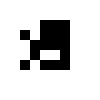

In [11]:
Gray.(noisySquare())

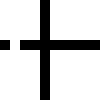

In [13]:
Gray.(noisyCross())

In [14]:
img_Num = 100

100

In [15]:
squares = [vec(noisySquare()) for i in 1:img_Num];
crosses = [vec(noisyCross()) for i in 1:img_Num];

In [16]:
Gray.(squares[1])

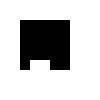

In [17]:
reshape( Gray.(squares[1]) , NN , NN )

In [18]:
size( squares )

(100,)

In [22]:
real_data = vcat( squares , crosses )
size( real_data )

(200,)

In [46]:
#data must be in WxHxCxN but for generator it is 1 d entry so that is HxCxN
tmp = Flux.stack( real_data , dims=2 )
display( size( tmp ) )
real_data_HCN = Flux.unsqueeze( tmp , dims = 2 )
size( real_data_HCN )

(100, 200)

(100, 1, 200)

In [163]:
latent_dim = 10
function MakeZvectors( batch_num )
    return rand( latent_dim , batch_num )
end

MakeZvectors (generic function with 1 method)

In [145]:

m_gen = Chain( 
      Dense( latent_dim => 100 ) , 
      BatchNorm(100,relu),
      x->reshape( x , 5 , 5 , 4 , : ) , #make into WHCN
      ConvTranspose( (4,4) , 4 => 2 ; stride = 1, pad = 1 ) ,
      BatchNorm( 2 , relu ) ,
      ConvTranspose( (5,5) , 2 => 1 ; stride = 1, pad = 1 ) , 
      ConvTranspose( (5,5) , 1 => 1 ; stride = 1, pad = 1 ) , 
      sigmoid
    )

Chain(
  Dense(10 => 100),                     # 1_100 parameters
  BatchNorm(100, relu),                 # 200 parameters, plus 200
  var"#93#94"(),
  ConvTranspose((4, 4), 4 => 2, pad=1),  # 130 parameters
  BatchNorm(2, relu),                   # 4 parameters, plus 4
  ConvTranspose((5, 5), 2 => 1, pad=1),  # 51 parameters
  ConvTranspose((5, 5), 1 => 1, pad=1),  # 26 parameters
  NNlib.σ,
)         # Total: 12 trainable arrays, 1_511 parameters,
          # plus 4 non-trainable, 204 parameters, summarysize 8.332 KiB.

In [172]:
genImg1 = m_gen( MakeZvectors( 1 ) )
genImg1[:,:,:,1]

10×10×1 Array{Float64, 3}:
[:, :, 1] =
 0.493144  0.508905  0.493317  0.476708  …  0.512633  0.504794  0.496547
 0.504662  0.492216  0.505276  0.52541      0.478426  0.500158  0.499733
 0.498955  0.495857  0.504482  0.498669     0.522445  0.502241  0.499822
 0.501606  0.506502  0.515751  0.501729     0.495303  0.514056  0.503193
 0.507208  0.514434  0.477122  0.521796     0.485266  0.507382  0.522328
 0.496314  0.506437  0.539887  0.483845  …  0.49131   0.481076  0.506164
 0.50133   0.487627  0.492163  0.529499     0.515026  0.478933  0.480938
 0.498819  0.507307  0.485117  0.4927       0.514768  0.480432  0.472229
 0.500274  0.494775  0.506424  0.497468     0.499567  0.504829  0.479597
 0.496419  0.491963  0.476964  0.477826     0.496769  0.505999  0.492738

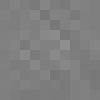

In [173]:
Gray.(genImg1[:,:,1,1])

In [174]:
m_dis = Chain(
      Conv( (4,4) , 1 => 1 , stride = 1 , pad = 1 ) ,
      relu ,
      Conv( (4,4) , 1 => 1 , stride = 1 , pad = 1 ) ,
      relu ,
      Flux.flatten ,
      Dense( 64 => 10 , relu ) ,
      Dense( 10 => 1 ) ,
      sigmoid
    )

Chain(
  Conv((4, 4), 1 => 1, pad=1),          # 17 parameters
  NNlib.relu,
  Conv((4, 4), 1 => 1, pad=1),          # 17 parameters
  NNlib.relu,
  Flux.flatten,
  Dense(64 => 10, relu),                # 650 parameters
  Dense(10 => 1),                       # 11 parameters
  NNlib.σ,
)                   # Total: 8 arrays, 695 parameters, 3.668 KiB.

In [167]:
m_dis( genImg1[:,:,:,1:2] )

1×2 Matrix{Float64}:
 0.502735  0.501062

In [175]:
function generator_loss( fake_output ) 
    logitbinarycrossentropy( fake_output , 1 )
end

generator_loss (generic function with 1 method)

In [176]:
function discriminator_loss( real_output , fake_output )
    real_loss = logitbinarycrossentropy( real_output , 1 )
    fake_loss = logitbinarycrossentropy( fake_output , 0 )
    return real_loss + fake_loss
end

discriminator_loss (generic function with 1 method)

In [177]:
function train_generator( gen , dscr , opt_gen , batch_num )
    noise = MakeZvectors( batch_num )
    # Taking gradient
    loss, grads = Flux.withgradient( gen ) do gen
        generator_loss( dscr( gen( noise ) ) )
    end
    update!( opt_gen , gen , grads[1] )
    return loss
end

train_generator (generic function with 1 method)

In [183]:
function train_discriminator!( gen , dscr , x , opt_dscr , batch_num )
    noise = MakeZvectors( batch_num )
    fake_input = gen( noise )
    # Taking gradient
    loss, grads = Flux.withgradient(dscr) do dscr
        discriminator_loss( dscr( x ) , dscr( fake_input ) )
    end
    update!( opt_dscr , dscr , grads[1] )
    return loss
end

train_discriminator! (generic function with 1 method)

In [186]:
opt_dis = Flux.setup( Adam( 0.001 ) , m_dis )
opt_gen = Flux.setup( Adam( 0.001 ) , m_gen );

In [ ]:
for epoch in 1:100
    for x in data
        
        loss_dscr = train_discriminator( m_gen , m_dis , x , opt_dis )
        loss_gen = train_generator( m_gen, m_dis , x , opt_gen )
         
    end
    
end